<a href="https://colab.research.google.com/github/janaahmeed/codealpha_tasks/blob/main/code_Alpha_task2_(Emotion_Recognition_from_Speech_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'toronto-emotional-speech-set-tess' dataset.
Path to dataset files: /kaggle/input/toronto-emotional-speech-set-tess


After framing, each frame is multiplied by a Hamming window to reduce spectral leakage before silence detection and further feature extraction.  
# When you use librosa.feature.mfcc, framing + windowing (Hamming) are already applied internally by default.

y>> the audio time-series signal , Compute MFCC features from audio signal lf sampled at fs Hz
y(t) = audio_signal
mfcc(y=audio_signal)

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
def display_wave (data,sr,emotion):
 plt.rcParams['figure.figsize'] = (18,4)
 plt.title(emotion,size=20)
 librosa.display.waveplot(data,sr=sr)
 plt.show()

Always join files with root, never dirs.

In [4]:

import os
import numpy as np

x, y = [], []
emotion_map = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "ps": 6
}

for root, dirs, files in os.walk(path):
    for _file in files:
        if _file.endswith(".wav"):
            file_path = os.path.join(root, _file)

            lf, fs = librosa.load(file_path, duration=3.0)

            y_trimmed, _ = librosa.effects.trim(lf ,top_db=25 )  # 20–30 is common for speech

            mfccs = librosa.feature.mfcc(
                y=y_trimmed,
                sr=fs,
                n_mfcc=40,
                n_fft=2048,
                hop_length=512,
                window='hamming')
            mfccs = mfccs.T # (time_steps, n_mfcc)
            # Why? LSTM expects time dimension first

            x.append(mfccs)
            emo_str = _file.split("_")[-1].replace(".wav", "")
            emo = emotion_map[emo_str]
            y.append(emo)


#(n_mfcc, time_frames) >>shape mfcc


#NumPy arrays require equal shapes
#Your MFCCs are variable-length sequences >> so we neednot ( Pad for CNN / Use sequence models (LSTM) / Use tf.keras.preprocessing.sequence.pad_sequences)
#“Don’t force uniform shape — store each MFCC as a separate object” if duration is fixed we donot need for it
#so type object
x = np.array(x, dtype=object)
y = np.array(y)

print(x.shape, y.shape)




(5600,) (5600,)


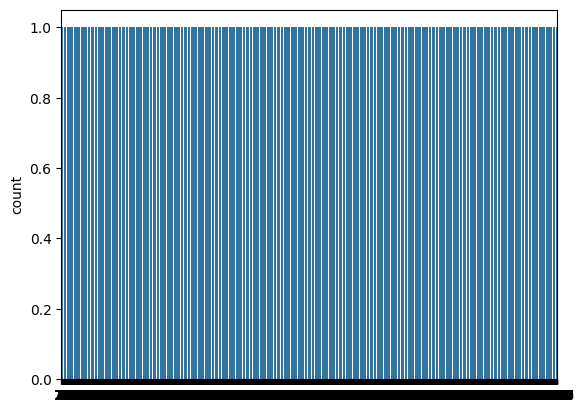

In [5]:
import seaborn as sns
sns.countplot(y)
plt.show()

In [6]:
import tensorflow as tf
x=tf.keras.preprocessing.sequence.pad_sequences(x ,padding='post')

#for conv2d new dimansion to adapt MFCC inputs for convolutional layers.
x=x[..., np.newaxis]


//CNN / LSTM

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test  = (X_test  - X_train.mean()) / X_train.std()


In [9]:
np.bincount(y_train)


array([640, 640, 640, 640, 640, 640, 640])

MFCC features have limited frequency resolution, so aggressive pooling across both axes may collapse feature maps.
We therefore apply pooling mainly along the time axis and preserve frequency information.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization,
    TimeDistributed, Flatten,
    LSTM, Dense, Dropout
)
num_classes= len(np.unique(y))

model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

# CNN block 1
model.add(Conv2D(64, (4, 4), activation='relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2, 1)))  # ↓ time only (1-2)=-1
model.add(BatchNormalization())

# CNN block 2 (SAFE kernel)
model.add(Conv2D(128, (4, 4), activation='relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(BatchNormalization())

# Prepare for LSTM
model.add(TimeDistributed(Flatten()))
# LSTM
model.add(LSTM(256, return_sequences=False))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
#output
model.add(Dense(num_classes, activation='softmax'))


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 40, 64)    │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 40, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 40, 128)   │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 126, 40, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 126, 5120)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │     5,506,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,672,903 (21.64 MB)

 Trainable params: 5,672,519 (21.64 MB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
print(y_test.dtype)

int64


In [ ]:
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64
)


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 2011s 18s/step - accuracy: 0.2531 - loss: 1.8208 - val_accuracy: 0.2824 - val_loss: 2.0893
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 2039s 18s/step - accuracy: 0.6424 - loss: 0.9820 - val_accuracy: 0.1920 - val_loss: 2.2616
Epoch 3/20
 90/112 ━━━━━━━━━━━━━━━━━━━━ 6:20 17s/step - accuracy: 0.8183 - loss: 0.5655

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Emotion Confusion Matrix")
plt.show()


In [ ]:
print(classification_report( y_test, y_pred, target_names=le.classes_))

In [ ]:
X_train.shape
